# Gaussian processes and Bayesian optimization

In this assignment we will use <a href="http://sheffieldml.github.io/GPy/">GPy</a> and <a href="http://sheffieldml.github.io/GPyOpt/">GPyOpt</a> libraries to deal with gaussian processes. These libraries provide quite simple and inuitive interfaces for training and inference.

### Setup
Load auxiliary files and then install and import the necessary libraries.

In [1]:
import numpy as np
import GPy
import GPyOpt
import matplotlib.pyplot as plt
from sklearn.svm import SVR
import sklearn.datasets
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
import time

## Gaussian processes: GPy (<a href="http://pythonhosted.org/GPy/">documentation</a>)

We will start with a simple regression problem, for which we will try to fit a Gaussian Process with RBF kernel.

In [2]:
def generate_points(n=25, noise_variance=0.0036):
    np.random.seed(777)
    X = np.random.uniform(-3., 3., (n, 1))
    y = np.sin(X) + np.random.randn(n, 1) * noise_variance**0.5
    return X, y
    
def generate_noise(n=25, noise_variance=0.0036):
    np.random.seed(777)
    X = np.random.uniform(-3., 3., (n, 1))
    y = np.random.randn(n, 1) * noise_variance**0.5
    return X, y

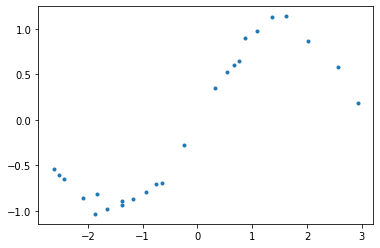

In [3]:
# Create data points
X, y = generate_points()
plt.plot(X, y, '.')
plt.show()

To fit a Gaussian Process, we will need to define a kernel. For Gaussian (GBF) kernel we can use `GPy.kern.RBF` function.

We choose RBF kernel with variance 1.5 and length-scale parameter 2 for 1D samples and compute value of the kernel between points `X[5]` and `X[9]`. 

In [24]:
kernel = GPy.kern.RBF(input_dim=1, variance=1.5, lengthscale=2.)
kernel_59 = kernel.K(X)[5, 9]
kernel_59

1.0461813545396959

Let's fit GP into generated data using the kernel above. Then we find the predicted mean and vairance at position $x=1$.

In [29]:
position = np.array([[1]])
model = GPy.models.GPRegression(X, y, kernel)
mean = model.predict(position)[0]
variance = model.predict(position)[1]
mean, variance

(array([[0.66467749]]), array([[1.10014782]]))

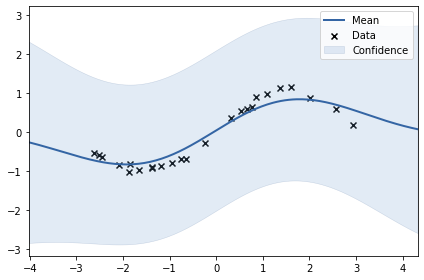

In [30]:
model.plot()
plt.show()

We see that the model didn't fit the data quite well. Let's try to fit kernel and noise parameters automatically as discussed in the lecture! You can see the current parameters below:

In [31]:
model

GP_regression.,value,constraints,priors
rbf.variance,1.5,+ve,
rbf.lengthscale,2.0,+ve,
Gaussian_noise.variance,1.0,+ve,


We optimize length-scale, variance and noise component of the model just by using the *optimize* method of the model:

In [32]:
model.optimize()
print(model)


Name : GP regression
Objective : -18.351767754167305
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  rbf.variance             |     0.7099385903482573  |      +ve      |        
  rbf.lengthscale          |     1.6252681834583018  |      +ve      |        
  Gaussian_noise.variance  |  0.0038978707543180927  |      +ve      |        


We can easily see the imporvement below:

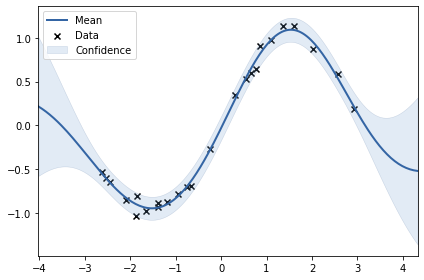

In [34]:
model.plot()
plt.show()

As we can see, the process generates outputs just right. Let's see if GP can distinguish noise and signal.

Generate two datasets: sinusoid wihout noise and samples from gaussian noise. Optimize kernel parameters and find the optimal values of noise component.

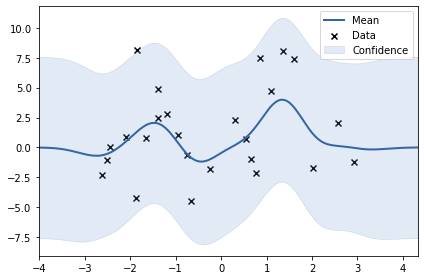

In [36]:
X, y = generate_noise(noise_variance=10) # data with noise
k = GPy.kern.RBF(input_dim=1)
model = GPy.models.GPRegression(X, y, k)

model.optimize()

model.plot()
plt.show()



In [39]:
model

GP_regression.,value,constraints,priors
rbf.variance,4.840661337062973,+ve,
rbf.lengthscale,0.4624141444416375,+ve,
Gaussian_noise.variance,10.143215047293625,+ve,


In [40]:
model.Gaussian_noise.variance

index,GP_regression.Gaussian_noise.variance,constraints,priors
[0],10.14321505,+ve,


In [41]:
So GP could find a good extimation of the noise variance.

SyntaxError: invalid syntax (<ipython-input-41-17b3aa5c3518>, line 1)

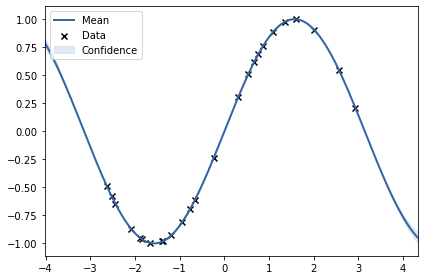

In [42]:
X, y = generate_points(noise_variance=0) # data without noise

model = GPy.models.GPRegression(X, y, k)

model.optimize()

model.plot()
plt.show()

In [43]:
print(model)


Name : GP regression
Objective : -140.28957451789958
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  rbf.variance             |       4.025037839763786  |      +ve      |        
  rbf.lengthscale          |      2.6455878696286192  |      +ve      |        
  Gaussian_noise.variance  |  1.5071540413599144e-14  |      +ve      |        


In [44]:
model.Gaussian_noise.variance

index,GP_regression.Gaussian_noise.variance,constraints,priors
[0],0.00000000,+ve,


which shows GP recognizes that this is data without noise!

## Sparse GP
Now let's consider the speed of GP. We will generate a dataset of 3000 points and measure the time that is consumed for prediction of mean and variance for each point. We will then try to use inducing inputs and find the optimal number of points according to quality-time tradeoff. We know that GP sparse should be faster because it only uses afew points to find the fitting curve whithout sacrificing too much of the quality of prediction.

For the sparse model with inducing points, we should use ```GPy.models.SparseGPRegression``` class. we can set the number of inducing inputs with parameter ```num_inducing``` and optimize their positions and values with ```.optimize()``` call.

Create a dataset of 1000 points and fit GPRegression. Measure time for predicting mean and variance at position $x=1$. Then fit `SparseGPRegression` with 10 inducing inputs and repeat the experiment. Report speedup as a ratio between consumed time without and with inducing inputs.

In [45]:
X, y = generate_points(1000)

In [48]:
start = time.time()
model = GPy.models.GPRegression(X, y, k)
mean = model.predict(position)[0] 
variance = model.predict(position)[1]
time_gp = time.time()-start
time_gp

0.19282793998718262

In [49]:
start = time.time()
model = GPy.models.SparseGPRegression(X, y, k)
mean = model.predict(position)[0] 
variance = model.predict(position)[1]
time_sgp = time.time()-start
time_sgp

0.028563261032104492

which is faster with good quality as shown below:

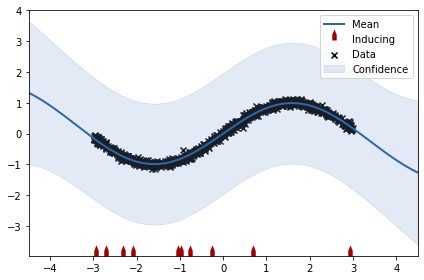

In [50]:
model.plot()
plt.show()

## Bayesian optimization: GPyOpt (<a href="http://pythonhosted.org/GPyOpt/">documentation</a>, <a href="http://nbviewer.jupyter.org/github/SheffieldML/GPyOpt/blob/master/manual/index.ipynb">tutorials</a>)

In this part of the assignment, we will try to find optimal hyperparameters to XGBoost model! We will use data from a small competition to speed things up, but keep in mind that the approach works even for large datasets.

We will use diabetes dataset provided in sklearn package.

In [51]:
dataset = sklearn.datasets.load_diabetes()
X = dataset['data']
y = dataset['target']

We will use cross-validation score to estimate accuracy and our goal will be to tune: ```max_depth```, ```learning_rate```, ```n_estimators``` parameters of XGBoost model. The baseline MSE with default XGBoost parameters is $0.2$. Let's see if we can do better. First, we have to define optimization function and domains.

In [52]:
# Score. Optimizer will try to find minimum, so we will add a "-" sign.
def f(parameters):
    parameters = parameters[0]
    score = -cross_val_score(
        XGBRegressor(learning_rate=parameters[0],
                     max_depth=int(parameters[2]),
                     n_estimators=int(parameters[3]),
                     gamma=int(parameters[1]),
                     min_child_weight = parameters[4]), 
        X, y, scoring='neg_mean_squared_error'
    ).mean()
    score = np.array(score)
    return score

In [53]:
baseline = -cross_val_score(
    XGBRegressor(), X, y, scoring='neg_mean_squared_error'
).mean()
baseline

4217.028096646883

In [54]:
# Bounds (NOTE: define continuous variables first, then discrete!)
bounds = [
    {'name': 'learning_rate',
     'type': 'continuous',
     'domain': (0, 1)},

    {'name': 'gamma',
     'type': 'continuous',
     'domain': (0, 5)},

    {'name': 'max_depth',
     'type': 'discrete',
     'domain': (1, 50)},

    {'name': 'n_estimators',
     'type': 'discrete',
     'domain': (1, 300)},

    {'name': 'min_child_weight',
     'type': 'discrete',
     'domain': (1, 10)}
]

In [55]:
np.random.seed(777)
optimizer = GPyOpt.methods.BayesianOptimization(
    f=f, domain=bounds,
    acquisition_type ='MPI',
    acquisition_par = 0.1,
    exact_eval=True
)

In [56]:
max_iter = 50
max_time = 60
optimizer.run_optimization(max_iter, max_time)

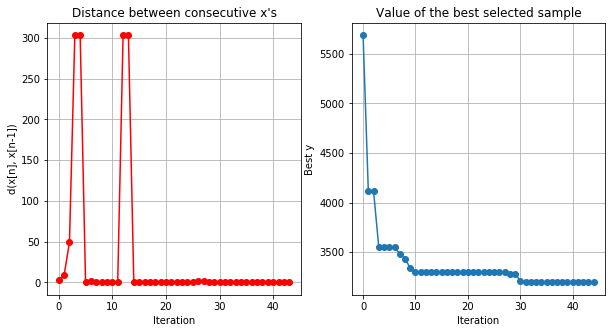

In [57]:
optimizer.plot_convergence()

Best values of parameters:

In [58]:
optimizer.X[np.argmin(optimizer.Y)]

array([4.00490607e-02, 1.28080648e+00, 1.00000000e+00, 3.00000000e+02,
       1.00000000e+00])

In [59]:
print('MSE:', np.min(optimizer.Y),
      'Gain:', np.abs(baseline - np.min(optimizer.Y))/baseline*100)

MSE: 3193.5261235600055 Gain: 24.270693712017284


We were able to get 9% boost without tuning parameters by hand! Let's try this on SVR. 

We try to find optimal values for three parameters: `C`, `epsilon` and `gamma`. We use range (1e-5, 1000) for `C`, (1e-5, 10) for `epsilon` and `gamma`. We use MPI as an acquisition function with weight 0.1. 

In [60]:
from sklearn.svm import SVR

In [61]:
domains = [
    {'name': 'C',
     'type': 'continuous',
     'domain': (1e-5, 1000)},

    {'name': 'epsilon',
     'type': 'continuous',
     'domain': (1e-5, 10)},

    {'name': 'gamma',
     'type': 'continuous',
     'domain': (1e-5, 10)}]

def f(parameters):
    parameters = parameters[0]
    score = -cross_val_score(
        SVR(C=parameters[0],
                     epsilon=parameters[1],
                     gamma=parameters[2]),
        X, y, scoring='neg_mean_squared_error'
    ).mean()
    score = np.array(score)
    return score


In [62]:
baseline = -cross_val_score(
    SVR(), X, y, scoring='neg_mean_squared_error'
).mean()
baseline

4976.655882526393

In [63]:
np.random.seed(777)
optimizer = GPyOpt.methods.BayesianOptimization(
    f=f, domain=domains,
    acquisition_type ='MPI',
    acquisition_par = 0.1,
    exact_eval=True
)

In [68]:
max_iter = 100
max_time = 400
optimizer.run_optimization(max_iter, max_time)

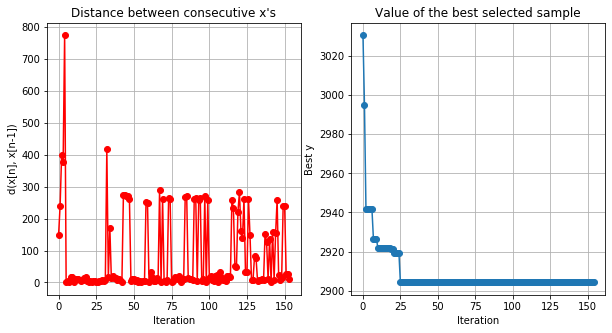

In [69]:
optimizer.plot_convergence()

In [71]:
optimizer.X[np.argmin(optimizer.Y)]

array([41.20854258,  2.44201122, 10.        ])

In [72]:
np.min(optimizer.Y)

2904.220046387097

In [73]:
baseline / (baseline - np.min(optimizer.Y))*100

240.13558324668415

The boost in improvement that you got after tuning hyperparameters is 240%.

Bayesian optimization is very useful when we can not find the true value of a function for example, in the case we dont havea formula for the function. An example of this is when we want to tune hyperparameters of neural network. But when it we can easilt find the value of the function, it is better to do random search as training a bayesian model could be time-consuming anyways. For wxample, we would use random search for a simple regression on a small data set.